## Download the data

In [1]:
!mkdir Dataset
!wget  https://zenodo.org/records/7189381/files/trainX.npy?download=1  -O Dataset/Xdata.npy
!wget  https://zenodo.org/records/7189381/files/trainY.npy?download=1  -O Dataset/Ydata.npy

--2025-08-28 08:19:26--  https://zenodo.org/records/7189381/files/trainX.npy?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293339264 (280M) [application/octet-stream]
Saving to: ‘Dataset/Xdata.npy’

Dataset/Xdata.npy   100%[===================>] 279.75M  3.54MB/s    in 1m 46s  

2025-08-28 08:21:13 (2.64 MB/s) - ‘Dataset/Xdata.npy’ saved [293339264/293339264]

--2025-08-28 08:21:13--  https://zenodo.org/records/7189381/files/trainY.npy?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73334912 (70M) [application/octet-stream]
Saving to: ‘Dataset/Ydata.npy’

Dataset/Ydata.npy   100%[===================>]  69.94M  5.14MB/s    in 17s     

20

## Prepare paths of input images and target segmentation masks

In [3]:
import numpy as np #numpy numerical python
import tensorflow as tf # tensorflow it is mostly used for deep learning tensor manipulation
import keras # backend of tensorflow
import matplotlib.pyplot as plt # plotting
from sklearn.model_selection import train_test_split # split the dtaset into training and test
import sklearn # Accuracy assessment,
from tensorflow.keras import models
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential

In [4]:
Xdata = np.load("XData01.npy")
Ydata = np.load("YData01.npy")
print(f"the shape of input image matrix is {Xdata.shape}")

the shape of input image matrix is (35, 16, 16, 4)


## What does one input image and corresponding segmentation mask look like?

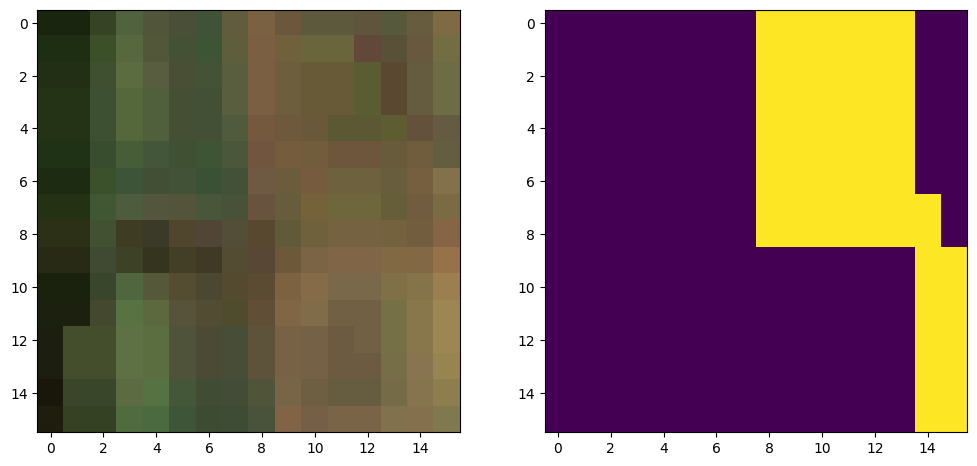

In [5]:
n = 20 # sample number
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) # making a subplot of 1 row 2 columns
ax[0].imshow(Xdata[n, :, :, :3].transpose((0, 1, 2))) #satellite image
ax[1].imshow(Ydata[n, :, :, 0]) #Ground Truth

ax[0].ticklabel_format(useOffset=False, style="plain")
ax[1].ticklabel_format(useOffset=False, style="plain")

## Prepare dataset to train validate and test the model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    Xdata, Ydata, test_size=0.3, random_state=42
)

## Prepare U-Net model

In [7]:
def down_block(x, filters, use_maxpool=True): # Function for down block
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    if use_maxpool == True:
        return MaxPooling2D(strides=(2, 2))(x), x
    else:
        return x


def up_block(x, y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis=3)([x, y])
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # in the second convolution layer in decoder we do not
    #  need to upsample or concatenate because it has been done already
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # No max pooling because we do not need to decrease the size

    return x


def get_model(input_size=(128, 128, 4), *, classes, dropout):
    filter = [64, 128, 256, 512, 1024]
    # encode
    input = Input(shape=input_size)
    x, temp1 = down_block(input, filter[0]) #Calling the function
    x, temp2 = down_block(x, filter[1])
    x, temp3 = down_block(x, filter[2])
    x, temp4 = down_block(x, filter[3])
    x = down_block(x, filter[4], use_maxpool=False)
    # decode
    x = up_block(x, temp4, filter[3])
    x = up_block(x, temp3, filter[2])
    x = up_block(x, temp2, filter[1])
    x = up_block(x, temp1, filter[0])
    x = Dropout(dropout)(x)

    output = Conv2D(classes, 1, activation="sigmoid")(x)


    model = models.Model(input, output, name="unet")
    model.summary()
    return model


# Build model
model = get_model(input_size=(16, 16, 4), classes=1, dropout=0.2)
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 16, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 64)  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 128) │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 4, 4, 256) │          0 │ batch_normalizat

 Total params: 31,403,073 (119.79 MB)

 Trainable params: 31,391,297 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 16, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     36,928 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 64)  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 128) │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 4, 4, 256) │          0 │ batch_normalizat

 Total params: 31,403,073 (119.79 MB)

 Trainable params: 31,391,297 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Train the model

In [10]:
# Compile model for training
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(),
        #tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)


def trainmodel(model, xdata, ydata):
    NUMBER_EPOCHS = 20
    filepath = "checkpointMaping.keras"
    BATCH_SIZE = 32

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch"
    )
    print(type(xdata), type(ydata))
    hist = model.fit(
        x=xdata,
        y=ydata,
        epochs=NUMBER_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # auto validate using 20% of random samples at each epoch
        verbose=1,
        callbacks=[model_checkpoint_callback],

    )
    return hist

In [11]:
trainmodel(
    model,
    np.array(X_train, dtype=np.float32),
    np.expand_dims(np.array(y_train, dtype=np.float32), axis=-1),
)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.4940 - auc_1: 0.8869 - loss: 0.7508 - precision_1: 0.3091 - recall_1: 0.9791 - val_accuracy: 0.1445 - val_auc_1: 0.4840 - val_loss: 2.6129 - val_precision_1: 0.0821 - val_recall_1: 0.9500
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6071 - auc_1: 0.9322 - loss: 0.6160 - precision_1: 0.3669 - recall_1: 0.9773 - val_accuracy: 0.1422 - val_auc_1: 0.4792 - val_loss: 2.2556 - val_precision_1: 0.0819 - val_recall_1: 0.9500
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7383 - auc_1: 0.9701 - loss: 0.4879 - precision_1: 0.4694 - recall_1: 0.9836 - val_accuracy: 0.1320 - val_auc_1: 0.4832 - val_loss: 2.2248 - val_precision_1: 0.0810 - val_recall_1: 0.9500
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8322 - auc_1: 0.9804 - loss: 0.4141 - precision_1: 0.5858 - recall_1: 0.9818 - val_accuracy: 0.1242 - val_auc_1: 0.4927 - val_loss: 2.2850 - v

## Visualize predictions

In [17]:
# Generate predictions for all images in the validation set
val_preds = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


In [18]:
preds = val_preds
preds[preds > 0.50] = 1
preds[preds <= 0.50] = 0
sklearn.metrics.accuracy_score(y_test.flatten(), preds.flatten())

0.18572443181818182

In [19]:
preds = val_preds
preds[preds > 0.50] = 1
preds[preds <= 0.50] = 0
sklearn.metrics.f1_score(y_test.flatten(), preds.flatten())

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

Text(0.5, 1.0, 'Image')

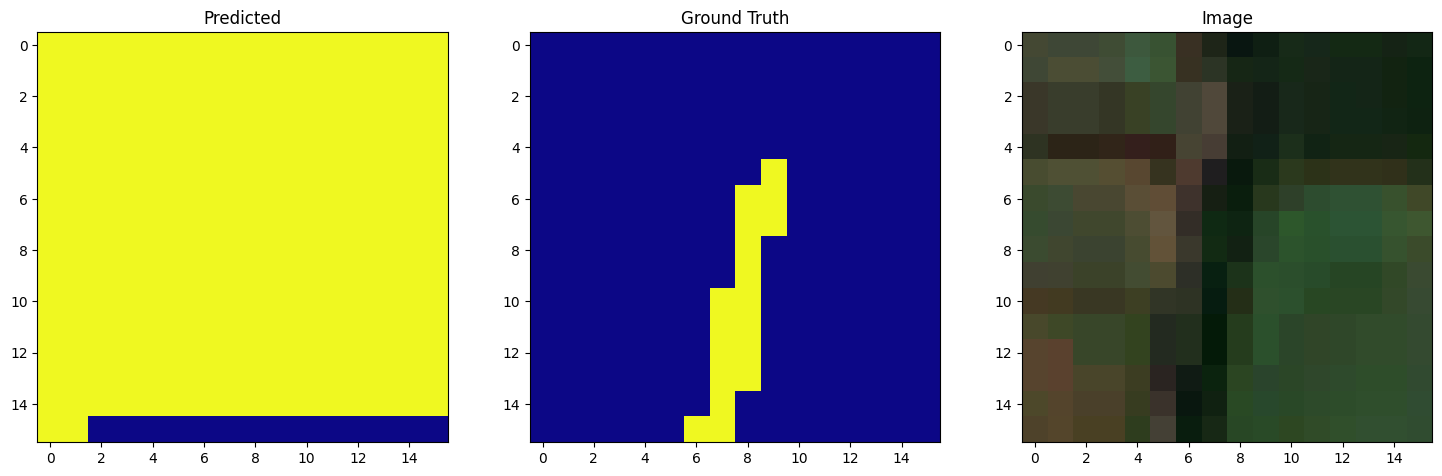

In [22]:
n = 3  # sample number
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
im1 = ax[0].imshow(
    val_preds[n, :, :, :3].transpose((0, 1, 2)), vmin=0, vmax=1.0, cmap="plasma"
)
im2 = ax[1].imshow(y_test[n, :, :, 0], cmap="plasma")

ax[2].imshow(X_test[n, :, :, :3].transpose((0, 1, 2)))

ax[0].ticklabel_format(useOffset=False, style="plain")
ax[1].ticklabel_format(useOffset=False, style="plain")
ax[2].ticklabel_format(useOffset=False, style="plain")

ax[0].set_title("Predicted")
ax[1].set_title("Ground Truth")
ax[2].set_title("Image")

# fig.colorbar(im1, ax=ax[0])
# fig.colorbar(im2, ax=ax[1])

In [23]:
model.save("shape.keras")